

**Investing in Construction and Infastructure Companies Including Commercial Aerospace and Defense Industries**

There is a recurring need to maintain infrastructure, not only for highways but also for buildings that must meet updated safety codes. Many construction and infrastructure companies can view this as an opportunity to collaborate with cities to develop plans for maintaining commercial buildings and roads. Additionally, investing in the defense and aerospace sectors can support strategic objectives when needed. Specializing and achieving new benchmarks in these industries is equally important, as they will remain significant in the long term, driving both economic and technological progress.

With increasing numbers of retirements in these sectors, it has become even more critical for them to uphold the highest standards of work while addressing workforce shortages. However, these industries are often not seen as lucrative by potential newcomers, leading to recruitment challenges. Recognizing their importance is essential, alongside prioritizing advancements in technology to meet future demands and maintain global competitiveness. This underscores the necessity of securing funding to support these companies, fostering innovation, growth, and the development of a skilled workforce to sustain these pivotal sectors over time.

**Why focus on aerospace and defence?**

Focusing on aerospace and defense industries is vital due to their significant role in supporting national infrastructure and technological innovation. These sectors contribute to economic stability and advancements in critical technologies. Investments in upgrading aging systems not only enhance operational efficiency but also drive innovation that can benefit other industries. Moreover, understanding the dynamics of these sectors allows for better resource allocation and strategic planning to address evolving global and domestic needs.


**Using Cluster Matrices to Study Covariant, Affine Price Behaviors between Construction/Infastruture Companies and Aerospace/Defence**

This study samples the recent price behavior of 10 companies, then traces the covariant, linear behavior, matrix style. Affine, or common mover groups are established, and presented interactively, for the viewer in a visual milieu.

Discussion of data pipeline used, and the subsequent data transformations needed in order to create this affine matrix, as well as the technical tools to facilitate this.

**Overview of Data Science Techniques**

The pipeline includes downloading data, introducing processing efficiencies, model building and cross validation, and cluster expression. I outline my steps as I take them, to arrive at a matrix of pricing which affords the following advantages.

The experiement was adapted from scikit-learn's own documentation, where the techniques were applied to the US stock market. My rendition creates several departures while adapting the advantage of Varoquaux's pipeline.[1]

1. The data ingest is fast, efficient, updateable and portable. Anyone may use this code to build a working model of US-traded stocks, and add symbols they wish to see, where I have missed them.
2. Data represent public, recently settled trades.
3. Local CPU resources are used in order to use notebook memory efficiently, and leverage local Linux resources.
4. Data remains in perpetuity for the analyst, or it may be rebuilt, using updated, daily trade series.
5. Data is built as a time series, in the OHLC format, where Opening, Closing, High and daily Low prices are located.
6. Clustering is aimed toward predictive use, where clusters can achieve whatever size is needed, to cluster affine, covariant items
7. Every company under consideration is measured for covariance against each other and to locate other trades in the same linear way
8. Sparse Inverse Covariance is the technique used to identify relationships between every item in the Matrix, and thus explose clusters of products, trading similarly. This is a list of connected items, trading conditionally upon the others.Thus the list is a useable, probable list of items which trade in the same way, over a week of US business.
9. An edge model exposes the borders for classification, and locates clusters at its discretion. Thus, no supervised limits are imposed in cluster formation.
10. Hyperparameters are determined via search with a predetermined number of folds, where each subset is used to locate model parameters, which are averaged at the close of the run.
11. Given the large volume of colinear features, a cross validation technique is used to 'lasso' model features.

**Building the Data Science Environment for Linux and Python**

Use the following commands to interface with your underlying linux environment. These may not need to be commented out, but will remain necessary each time a new kernel boot, in your notebook, takes place.

In [5]:
!pip install yfinance==0.2.40
!pip install vega_datasets
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.52
    Uninstalling yfinance-0.2.52:
      Successfully uninstalled yfinance-0.2.52
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.7 MB/s eta 0:00:00


**Data Ingest from Public Markets**

The free, common Yahoo Finace API is used to download data from all commodites you wish to see studied. This data will be stored persistently next to your notebook in common environments such as Binder.

Please note that if you deploy this notebook in Google Collab that the 37+ files downloaded will be erased between uses, but can be rebuilt easily each time you operate this notebook.

The data you download becomes permanently usable, and the ingest request below can be customized in order to grab more, or less data and at different intervals.[2]

I have included several exceptions to the download and renaming technique, in order to tolerate stocks with differing ticker symbols.

In [6]:
import yfinance as yf
from time import time,ctime, clock_gettime
from time import gmtime, time, time_ns

def ifs(input):
    ni = ''
    if input =='gff':
        input = 'GFF'
        ni = "GF=F"
    elif input == 'zff':
        input = 'ZFF'
        ni = "ZF=F"
    else:
        input = input.upper()
        ins = "="
        before = "F"
        ni = input.replace(before, ins + before , 1)
    print(ni)
    data = yf.download(
        tickers = ni,
        period = "5y",
        interval = "1d",
        group_by = 'ticker',
        auto_adjust = True,
        prepost = True,
        threads = True,
        proxy = None
    )
    epoch = ctime()
    filename = input
    data.to_csv(filename)
#!ls #only in jupy

**Trigger Data Downloads**

The following code customizes the stocks under investigation. In order to compare every commodity's price history versus the rest in your matrix, the lengths of the data captures are minimized to the length of the smallest data set. Thus, larger sets are only captured at the length of the smallest set.

The volatility of every price tick is calculated via [close price minus open price].

In [7]:
#read in csv data from each commodity capture, gather
#assign 'open' to an array, create df from arrays
import numpy as np
import pandas as pd
from  scipy.stats import pearsonr
symbol_dict = {"VLO":"Valero Energy", "XOM":"Exxon Corp", "JPM":"JP Morgan", "TGT":"Target Corp", "INTC":"Intel Corporation", "AMZN":"Amazon.com, Inc.", "RTX":"Raytheon Technologies Corp", "HD":"Home Depot Inc", "LMT":"Lockheed Martin Corp"}

sym, names = np.array(sorted(symbol_dict.items())).T

for i in sym:    #build all symbol csvs, will populate/appear in your binder. Use linux for efficient dp
  ifs(i)

quotes = []
lens = []
for symbol in sym:
    symbol = symbol.upper()
    t = pd.read_csv(symbol)
    lens.append(t.shape[0])
mm = np.amin(lens)-1
print("min length of data: ",mm)

for symbol in sym:
    symbol = symbol.upper()
    t = pd.read_csv(symbol)
    t= t.truncate(after=mm)
    quotes.append(t)
mi = np.vstack([q["Close"] for q in quotes]) #min
ma = np.vstack([q["Open"] for q in quotes]) #max

volatility = ma - mi


AMZN


[*********************100%%**********************]  1 of 1 completed


HD


[*********************100%%**********************]  1 of 1 completed


INTC


[*********************100%%**********************]  1 of 1 completed


JPM


[*********************100%%**********************]  1 of 1 completed


LMT


[*********************100%%**********************]  1 of 1 completed


RTX


[*********************100%%**********************]  1 of 1 completed


TGT


[*********************100%%**********************]  1 of 1 completed


VLO


[*********************100%%**********************]  1 of 1 completed


XOM


[*********************100%%**********************]  1 of 1 completed


min length of data:  1257


**Data Format**

After downloading this massive store of data, you should click on a file, in your project. Using the file browser, you will see a large quantity of new files.

When you open one, you will see the rows of new data.


**Cross Validate for Optimal Parameters: the Lasso**

Varoquaux's pipeline involves steps in the following two cells.

A set of clusters is built using a set of predefined edges, called the edge model. The volatility of every OHLC tick is fed into the edge model, in order to establish a covariance to each other.

The advantages of the Graphical Lasso model is that a cross validated average set of hyperparameters is located, then applied to cluster each stock. Thus, every stock is identified with other stockss which move in tandem, together, over seven days. I print the alpha edges below, and visualize this group.

Depending upon the markets when you run this study, more intensive clustering may take place at either end of the spectrum. This exposes the covariance between different groups, while exposing outlier clusters.

**Using the Interactive Graph**

Feel free to move your mouse into the graph, then roll your mouse. This will drill in/out and allow you to hover over data points. They will mape to the edges of the clusters, under investigation.




In [8]:
from sklearn import covariance
import altair as alt
alphas = np.logspace(-1.5, 1, num=15)
edge_model = covariance.GraphicalLassoCV(alphas=alphas)
X = volatility.copy().T
X /= X.std(axis=0)
l =edge_model.fit(X)
n= []
print(type(l.alphas))
for  i in range(len(l.alphas)):
    print(l.alphas[i])
    dict = {"idx":i , "alpha":l.alphas[i]}
    n.append(dict)

dd = pd.DataFrame(n)
alt.Chart(dd).mark_point(filled=True, size=100).encode(
    y=alt.Y('idx'),
    x=alt.X('alpha'),tooltip=['alpha'],).properties(
        width=800,
        height=400,
        title="Edges Present Within the Graphical Lasso Model"
    ).interactive()

<class 'numpy.ndarray'>
0.03162277660168379
0.047705826961439296
0.07196856730011521
0.10857111194022041
0.16378937069540642
0.2470911227985605
0.372759372031494
0.5623413251903491
0.8483428982440722
1.279802213997954
1.9306977288832505
2.9126326549087382
4.39397056076079
6.628703161826448
10.0


alt.Chart(...)

**Definining cluster Membership, by Covariant Affinity**

Clusters of covariant, affine moving stocks are established. This group is then passed into a dataframe so that the buckets of symbols can become visible.

In [9]:
import pandas as pd
import numpy as np

# Example setup (replace with your data)
clusters = 3
names = np.array(["AMZN", "HD", "INTC", "TGT"])
labels = np.array([0, 0, 1, 2])  # Example labels

# Initialize an empty DataFrame
gdf = pd.DataFrame(columns=["cluster", "symbols", "size", "names"])

# Populate the DataFrame using a loop
for i in range(clusters):
    l = names[labels == i]  # Adjust logic if needed
    ss = np.array(names)[labels == i]
    cluster_dict = {"cluster": (i + 1), "symbols": l, "size": len(l), "names": ss}
    gdf = pd.concat([gdf, pd.DataFrame([cluster_dict])], ignore_index=True)

print(gdf.head(15))


  cluster     symbols size       names
0       1  [AMZN, HD]    2  [AMZN, HD]
1       2      [INTC]    1      [INTC]
2       3       [TGT]    1       [TGT]


**Visualizing cluster and affine securities, by volatility**

The interactive graphic requires the user to hover over each dot, in teh scatter chart. The size of the security cluster pushes it to the top, where the user can study the members, whose prices move in covariant fashion.

I have experimented with laying the text of the securities cluster over the dots, but I find that the above table is most helpful, in identifying markets which move in tandem, and with similar price graphs. Also, as groups expand and contract, overlaying text on the chart below may prevent certain clusters from appearing. I appreciate spacing them out, and not congesting the chart.

The user is free to study where his or her chosen security may sit, in close relation to other globally relevant securities.

In [10]:
for i in gdf['cluster']:
    print("cluster ",i)
    d = gdf[gdf['cluster'].eq(i)]
    for j in d.names:
        print(j, ", ")

cluster  1
['AMZN' 'HD'] , 
cluster  2
['INTC'] , 
cluster  3
['TGT'] , 


In [11]:
import altair as alt
def runCluster():
    c = alt.Chart(gdf).mark_circle(size=60).encode(
        x= alt.X('cluster:N'),
        y= alt.Y('size:Q'),
        color='size:Q',
        tooltip=['names'],
        size=alt.Size('size:Q')
    ).properties(
        width=800,
        height=400,
        title="Top Global Stocks, Clustered by Affine Covariance"
    ).interactive()
    #.configure_title("Top Global Stocks, Clustered by Affine Covariance")

    chart =c
    return chart
runCluster()


alt.Chart(...)

**References**

1. Gael Varoquaux. Visualizing the Stock Market Structure. Scikit-Learn documentation pages, https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html
2. Ran Aroussi. YFinance API documents. https://github.com/ranaroussi/yfinance
3. The Altair Charting Toolkit. https://altair-viz.github.io/index.html

In [12]:
!pip install plotly

In [13]:
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime

df_symbol = pd.read_csv('AMZN')    #no .csv

In [14]:
df_symbol.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [41]:
df_symbol.head(3)

,Date,Open,High,Low,Close,Volume
0,2020-02-13,107.249496,108.514000,107.099998,107.493500,60636000
1,2020-02-14,107.783997,107.952003,106.294502,106.743500,52124000
2,2020-02-18,106.250999,108.303497,106.205498,107.783501,58912000


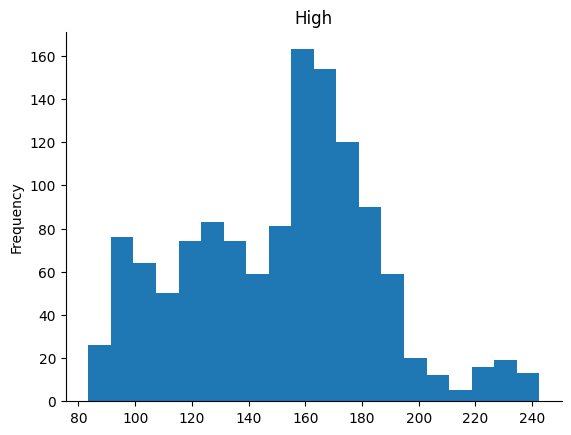

In [16]:
# @title High

from matplotlib import pyplot as plt
df_symbol['High'].plot(kind='hist', bins=20, title='High')
plt.gca().spines[['top', 'right',]].set_visible(False)

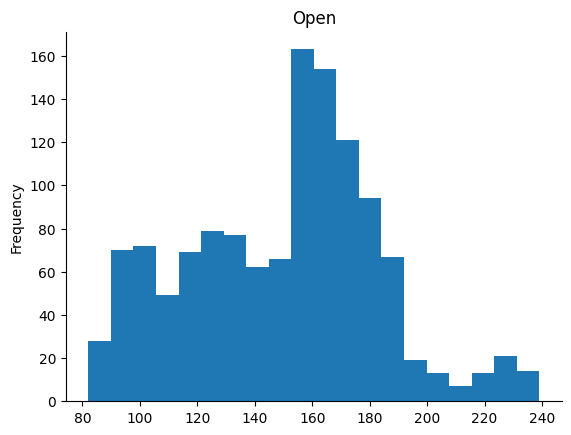

In [17]:
# @title Open

from matplotlib import pyplot as plt
df_symbol['Open'].plot(kind='hist', bins=20, title='Open')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [21]:
fig = go.Figure(data=[go.Candlestick(x=df_symbol['Date'],
                open=df_symbol['Open'],
                high=df_symbol['High'],
                low=df_symbol['Low'],
                close=df_symbol['Close'])])
fig.show()

In [23]:
import pandas as pd

# Define ticker symbols
tickers = ["LMT", "VLO", "RTX", "XOM", "INTC", "HD"]

# Initialize empty DataFrame
df2 = pd.DataFrame()

# Loop through each ticker and merge data
for ticker in tickers:
    temp_df = pd.read_csv(ticker, usecols=["Date", "Close"])  # Read CSV file
    temp_df.rename(columns={"Close": ticker}, inplace=True)   # Rename Close column to ticker symbol

    if df2.empty:
        df2 = temp_df  # First DataFrame sets the structure
    else:
        df2 = pd.merge(df2, temp_df, on="Date", how="inner")  # Merge on 'Date'

# Convert 'Date' to datetime format
df2["Date"] = pd.to_datetime(df2["Date"])

# Display the first few rows
print(df2.head())

        Date         LMT        VLO        RTX        XOM       INTC  \
0 2020-02-13  380.301697  67.826462  85.456184  48.064716  59.781246   
1 2020-02-14  383.057495  66.967499  85.679527  47.843838  59.630547   
2 2020-02-18  381.045258  66.870247  84.462402  47.236416  58.628872   
3 2020-02-19  380.109192  67.445618  84.127411  47.599285  59.488716   
4 2020-02-20  372.664185  68.207329  83.691910  47.220642  58.017227   

           HD  
0  214.849365  
1  217.216293  
2  216.250000  
3  215.984116  
4  218.980392  


In [24]:
df2.columns

Index(['Date', 'LMT', 'VLO', 'RTX', 'XOM', 'INTC', 'HD'], dtype='object')

In [25]:
df2.head(2)

,Date,LMT,VLO,RTX,XOM,INTC,HD
0,2020-02-13,380.301697,67.826462,85.456184,48.064716,59.781246,214.849365
1,2020-02-14,383.057495,66.967499,85.679527,47.843838,59.630547,217.216293


In [26]:
df_symbol.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [27]:
df_symbol['Close']

,Close
0,107.493500
1,106.743500
2,107.783501
3,108.511002
4,107.654999
...,...
1253,229.149994
1254,233.139999
1255,232.759995
1256,228.929993


In [28]:
# Using plotly.express
import plotly.express as px
fig = px.line(df_symbol, x='Date', y="Close") #contains daily price series
fig.show()

#Plotting the Clustered Stocks


In [29]:
#generate a Date column in gdf
def getDateColumn():
  df = pd.read_csv('LMT')  #CHOOSE an equity or vehicle for which you possess a Date index
  return df['Date']  #pandas series

In [30]:
symUpper = [x.upper() for x in sym] #make all symbols in sym to uppercase
# print(symUpper)
gdf = pd.DataFrame(columns=symUpper) #form a new global dataframe, gdf, for purpose of graphing
gdf['Date'] = getDateColumn()            #get a common index for dates, for every commodity or equity
for i in range(len(symUpper)):           #iterate the length of the uppercase symbols
  df_x = pd.read_csv( symUpper[i])       #create one dataframe to hold the csv contents
  gdf[symUpper[i]] = df_x['Close']       #extract the price series from the 'Closed' column
print(gdf.head(3))                       #print the resulting top three rows from the new gdf
# print(gdf.columns)


         AMZN          HD       INTC         JPM         LMT        RTX  \
0  107.493500  214.849365  59.781246  119.475555  380.301697  85.456184   
1  106.743500  217.216293  59.630547  119.111641  383.057495  85.679527   
2  107.783501  216.250000  58.628872  117.534569  381.045258  84.462402   

          TGT        VLO        XOM        Date  
0  104.469345  67.826462  48.064716  2020-02-13  
1  103.012001  66.967499  47.843838  2020-02-14  
2  104.664177  66.870247  47.236416  2020-02-18  


In [31]:
fig = px.line(gdf[(gdf["Date"] >= "2020-01-01") & (gdf["Date"] <= "2025-2-1")],
              x="Date", y=gdf.columns,
              hover_data={"Date": "|%B %d, %Y"},
              title='Study of Defence, Service, and Infrastructure Sectors in the Market')
fig.show()

In [32]:
gdf.columns

Index(['AMZN', 'HD', 'INTC', 'JPM', 'LMT', 'RTX', 'TGT', 'VLO', 'XOM', 'Date'], dtype='object')

In [33]:
type(gdf.columns)

pandas.core.indexes.base.Index

# **Market Trends Over the Past Five Years**

The dataset visualizes market trends from 2020 to 2025, highlighting movements in the defense, service, and energy sectors. Each stock follows its own volatility pattern, reflecting broader economic shifts and sector-specific catalysts.

Amazon (AMZN) and Home Depot (HD) stand out as top performers, with AMZN breaking past 600. Their steady upward trajectory suggests resilience in consumer demand and e-commerce dominance. In contrast, Lockheed Martin (LMT), JPMorgan (JPM), and Raytheon (RTX) display stable growth, moving in tandem. This clustering indicates institutional consistency, with these stocks likely benefiting from defense contracts and financial sector stability.

Energy stocks like Exxon Mobil (XOM) and Valero (VLO) exhibit higher volatility, reacting more to external forces such as oil prices and global production constraints. Unlike the technology and defense sectors, these stocks remain more sensitive to macroeconomic events, resulting in cyclical price swings rather than sustained upward trends.

A key shift occurs post-2023, where AMZN and HD diverge from the broader pack, signaling a possible sectoral decoupling. Defense-related stocks maintain a strong correlation, reinforcing their position as institutional holdings. Overall, we are starting to see a decreasing trend in price movement in early 2025. We will need to wait and see during the next FOMC meeting regarding interest rates.